# Importing Data and Dependencies / Liblaries

## Nessecarry installs

Written on device in vscode/jupyter notebook, thus requiring the installation of dependacies (uncomment if needed)

In [152]:
# %pip install contractions
# %pip install wordninja
# %pip install keras
# %pip install seaborn
# %pip install matplotlib
# %pip install nltk
# %pip install textblob

## Import Libraries

In [153]:
import sys
import time
import re
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import contractions
import wordninja

from textblob import TextBlob, Word

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eksudee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eksudee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eksudee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [154]:
# because i was running this in vs code
import time
start = time.time()

## Data

In [155]:
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

# Add a 'label' column to each DataFrame
fake_df['label'] = 'non-credible'
true_df['label'] = 'credible'

# Concatenate the DataFrames
df = pd.concat([fake_df, true_df], ignore_index=True)

# Display the first few rows of the combined DataFrame
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",non-credible
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",non-credible
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",non-credible
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",non-credible
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",non-credible


- Imports the pandas library for data manipulation.
- Loads two CSV files, 'Fake.csv' and 'True.csv', into separate DataFrames: `fake_df` and `true_df`.
- Adds a new column called `label` to each DataFrame to indicate whether the news is 'credible' or 'non-credible'.
- Concatenates the two DataFrames into a single DataFrame `df`, combining both credible and non-credible news articles.
- Displays the first few rows of the combined DataFrame to provide an overview of the merged dataset.

# EDA and Data Cleaning


## Basic EDA / Dataset Overview

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


The `df.info()` method provides a concise summary of the DataFrame

In [157]:
df.shape

(44898, 5)

The `df.shape` attribute returns a tuple representing the dimensions of the DataFrame.(rows and collumns)

The output `(44898, 5)` indicates that the DataFrame `df` contains 44,898 rows and 5 columns.

## Dropping non essential features

In [158]:
df = df.drop(columns=['subject', 'date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   44898 non-null  object
 1   text    44898 non-null  object
 2   label   44898 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


We dropped the `subject` and `date` columns because they are not essential for the initial analysis or modeling.
Removing these columns helps to focus on the main textual content (`title`, `text`) and the target label (`label`). 
Additionally it also simplifies the dataset and reduces noise.

## Combine Title and Text in to one collum

In [159]:
df['content'] = df['title'] + ' ' + df['text']
df = df.drop(columns=['title', 'text'])
df = df[['content', 'label']]
df.head()

,content,label
0,Donald Trump Sends Out Embarrassing New Year’...,non-credible
1,Drunk Bragging Trump Staffer Started Russian ...,non-credible
2,Sheriff David Clarke Becomes An Internet Joke...,non-credible
3,Trump Is So Obsessed He Even Has Obama’s Name...,non-credible
4,Pope Francis Just Called Out Donald Trump Dur...,non-credible


The code combines the "title" and "text" columns into a new "content" column, then removes the original "title" and "text" columns, leaving only "content" and "label" in the DataFrame. This simplifies the dataset by merging all relevant text into a single column for easier processing and analysis, and displays the first few rows of the updated DataFrame.

## Converting text to lowercase

In [160]:
df['content'] = df['content'].str.lower()
df.head()

,content,label
0,donald trump sends out embarrassing new year’...,non-credible
1,drunk bragging trump staffer started russian ...,non-credible
2,sheriff david clarke becomes an internet joke...,non-credible
3,trump is so obsessed he even has obama’s name...,non-credible
4,pope francis just called out donald trump dur...,non-credible


code that maps the `'content'` collumn of the DateFrame to itself after converting it in to lower case using the `.str.lower()` method

## Missing Values

In [161]:
print(df.isnull().sum())

content    0
label      0
dtype: int64



This code prints the number of missing (null) values in each column of the DataFrame `df

The output shows us that the dataset has no missing values

## Finding and Handling Duplicates

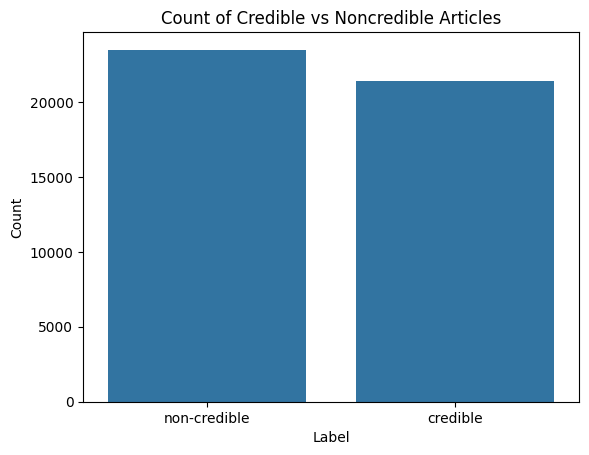

In [162]:
# Bar chart showing the count of credible and noncredible articles
sns.countplot(x='label', data=df)
plt.title('Count of Credible vs Noncredible Articles')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

The code takes the current DataFrame and uses the value_counts() method on the 'label' column to count the number of articles in each class (credible and non-credible).

In [163]:
duplicate_content = df[df.duplicated(subset='content')]
duplicate_content

,content,label
9942,hillary tweets message in defense of daca…oops...,non-credible
11446,former democrat warns young americans: “rioter...,non-credible
14925,[video] #blacklivesmatter terrorists storm dar...,non-credible
15892,house intel slaps subpoenas on mccain institut...,non-credible
15893,priceless! watch msnbc host’s shocked response...,non-credible
...,...,...
44709,france unveils labor reforms in first step to ...,credible
44744,guatemala top court sides with u.n. graft unit...,credible
44771,"europeans, africans agree renewed push to tack...",credible
44834,thailand's ousted pm yingluck has fled abroad:...,credible


In [164]:
print(duplicate_content['label'].value_counts())

label
non-credible    5573
credible         220
Name: count, dtype: int64


The code takes the duplicate_content DataFrame using ".value_count()" and displays the counts the number of articles in each class, The output shows that the most amount of duplicates are within the rows classified as "non-credible" articles at 5573 articles while only 220 "credible" artiles are duplicated

In [165]:
df = df.drop_duplicates(subset='content', keep='first').reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39105 entries, 0 to 39104
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  39105 non-null  object
 1   label    39105 non-null  object
dtypes: object(2)
memory usage: 611.1+ KB


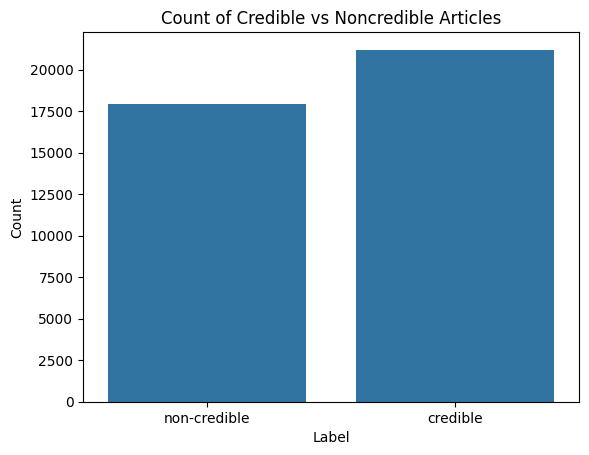

In [166]:

sns.countplot(x='label', data=df)
plt.title('Count of Credible vs Noncredible Articles')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [167]:
df

,content,label
0,donald trump sends out embarrassing new year’...,non-credible
1,drunk bragging trump staffer started russian ...,non-credible
2,sheriff david clarke becomes an internet joke...,non-credible
3,trump is so obsessed he even has obama’s name...,non-credible
4,pope francis just called out donald trump dur...,non-credible
...,...,...
39100,'fully committed' nato backs new u.s. approach...,credible
39101,lexisnexis withdrew two products from chinese ...,credible
39102,minsk cultural hub becomes haven from authorit...,credible
39103,vatican upbeat on possibility of pope francis ...,credible


## Handling Contractions

In [168]:
df['content'] = df['content'].apply(contractions.fix)

In [169]:
df['content'].iloc[0]

' donald trump sends out embarrassing new year’s eve message; this is disturbing donald trump just couldn t wish all americans a happy new year and leave it at that. instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  the former reality show star had just one job to do and he couldn t do it. as our country rapidly grows stronger and smarter, i want to wish all of my friends, supporters, enemies, haters, and even the very dishonest fake news media, a happy and healthy new year,  president angry pants tweeted.  2018 will be a great year for america! as our country rapidly grows stronger and smarter, i want to wish all of my friends, supporters, enemies, haters, and even the very dishonest fake news media, a happy and healthy new year. 2018 will be a great year for america!  donald j. trump (@realdonaldtrump) december 31, 2017trump s tweet went down about as welll as you d expect.what kind of president sends a new year s greeting like this 

## Finding and Handling usernames, hashtags, and emails

In [170]:
def count_users_hash(dataframe):

    email_count = dataframe['content'].str.count(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+').sum()
    print(f"Total email addresses: {email_count}")
    
    username_count = dataframe['content'].str.count(r'@[A-Za-z0-9_]{1,15}\b').sum()
    print(f"Total Twitter usernames: {username_count}")


count_users_hash(df)

Total email addresses: 44
Total Twitter usernames: 24782


In [171]:

def clean_text(text):
    
    text = re.sub(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', '', text)

    text = re.sub(r'@[A-Za-z0-9_]{1,15}\b', '', text)
    
    return text

df['content'] = df['content'].apply(clean_text)
count_users_hash(df)

Total email addresses: 0
Total Twitter usernames: 0


## Finding and Handling HTML tags and URL's

In [172]:
df['content'].iloc[0]

' donald trump sends out embarrassing new year’s eve message; this is disturbing donald trump just couldn t wish all americans a happy new year and leave it at that. instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  the former reality show star had just one job to do and he couldn t do it. as our country rapidly grows stronger and smarter, i want to wish all of my friends, supporters, enemies, haters, and even the very dishonest fake news media, a happy and healthy new year,  president angry pants tweeted.  2018 will be a great year for america! as our country rapidly grows stronger and smarter, i want to wish all of my friends, supporters, enemies, haters, and even the very dishonest fake news media, a happy and healthy new year. 2018 will be a great year for america!  donald j. trump () december 31, 2017trump s tweet went down about as welll as you d expect.what kind of president sends a new year s greeting like this despicable, pett

In [173]:
def count_links(dataframe):

    html_tag_count = df['content'].str.contains(r'<.*?>', regex=True).sum()
    url_count = df['content'].str.contains(r'http\S+|www\.\S+', regex=True).sum()
    dot_com_count = df['content'].str.count(r'\b\w+\.\w+\.(com|org|net|gov|edu|info|io|co|us|uk|in|au|ca|de|fr|ru|jp|cn|br|za)\b').sum()
    

    print(f"Links matching (abc.xyz.com(others)) pattern: {dot_com_count}")
    print(f"Rows with HTML tags: {html_tag_count}")
    print(f"Rows with URLs: {url_count}")

count_links(df)
df.shape

Links matching (abc.xyz.com(others)) pattern: 5845
Rows with HTML tags: 68
Rows with URLs: 2589


(39105, 2)

In [174]:

def clean_text_2(text):

    text = re.sub(r'\b\w+\.\w+\.(com|org|net|gov|edu|info|io|co|us|uk|in|au|ca|de|fr|ru|jp|cn|br|za)\b', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    return text

df['content'] = df['content'].apply(clean_text_2)
df.head()

,content,label
0,donald trump sends out embarrassing new year’...,non-credible
1,drunk bragging trump staffer started russian ...,non-credible
2,sheriff david clarke becomes an internet joke...,non-credible
3,trump is so obsessed he even has obama’s name...,non-credible
4,pope francis just called out donald trump dur...,non-credible


In [175]:
count_links(df)
df.shape

Links matching (abc.xyz.com(others)) pattern: 0
Rows with HTML tags: 0
Rows with URLs: 0


(39105, 2)

In [176]:
df['content'].iloc[0]

' donald trump sends out embarrassing new year’s eve message; this is disturbing donald trump just couldn t wish all americans a happy new year and leave it at that. instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  the former reality show star had just one job to do and he couldn t do it. as our country rapidly grows stronger and smarter, i want to wish all of my friends, supporters, enemies, haters, and even the very dishonest fake news media, a happy and healthy new year,  president angry pants tweeted.  2018 will be a great year for america! as our country rapidly grows stronger and smarter, i want to wish all of my friends, supporters, enemies, haters, and even the very dishonest fake news media, a happy and healthy new year. 2018 will be a great year for america!  donald j. trump () december 31, 2017trump s tweet went down about as welll as you d expect.what kind of president sends a new year s greeting like this despicable, pett

## Handling Special characters and Digits (non-word and non-whitespaces)

In [177]:
df = df.replace(to_replace=r'[^\w\s]', value='', regex=True)
df = df.replace(to_replace=r'\d', value='', regex=True)
df.head()

,content,label
0,donald trump sends out embarrassing new years...,noncredible
1,drunk bragging trump staffer started russian ...,noncredible
2,sheriff david clarke becomes an internet joke...,noncredible
3,trump is so obsessed he even has obamas name ...,noncredible
4,pope francis just called out donald trump dur...,noncredible


here the `df.replace()` function is used to replace all characters that are not(`^`) words ((a-z, A-Z), digits (0-9), and underscore (_)) (`\w`) or whitespaces (`\s`), and are replaces with an empty string (`value=''`). This is done to reduce noise and improve consistency as special characters often do not add any meaningful information to text classification and analytics casts and removing them helps standardize the text making future tokenizations and processing easier

the code also replaces all digits (`\d`) with and empty string

Note: '[^\w\s]' = NOT (`^`) words or whitespaces while '\d' = IS digits

In [178]:
# Count rows with extra (consecutive) white spaces in 'content'
extra_ws_mask = df['content'].str.contains(r'\s{2,}', regex=True)
extra_ws_count = extra_ws_mask.sum()
print(f"Rows with extra white spaces: {extra_ws_count}")

# Print an example row with extra white spaces, if any exist
if extra_ws_count > 0:
    example_row = df[extra_ws_mask].iloc[0]
    print("Example with extra white spaces:")
    print(example_row['content'])
else:
    print("No extra white spaces found in the dataset.")


Rows with extra white spaces: 38450
Example with extra white spaces:
 donald trump sends out embarrassing new years eve message this is disturbing donald trump just couldn t wish all americans a happy new year and leave it at that instead he had to give a shout out to his enemies haters and  the very dishonest fake news media  the former reality show star had just one job to do and he couldn t do it as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year  president angry pants tweeted   will be a great year for america as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year  will be a great year for america  donald j trump  december  trump s tweet went down about as welll as you d expectwhat kind of president sends a new year s greeting l

In [179]:
df['content'].iloc[0]

' donald trump sends out embarrassing new years eve message this is disturbing donald trump just couldn t wish all americans a happy new year and leave it at that instead he had to give a shout out to his enemies haters and  the very dishonest fake news media  the former reality show star had just one job to do and he couldn t do it as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year  president angry pants tweeted   will be a great year for america as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year  will be a great year for america  donald j trump  december  trump s tweet went down about as welll as you d expectwhat kind of president sends a new year s greeting like this despicable petty infantile gibberish only trump his lack of

## Handling extra whitespaces

In [180]:
# Remove extra (consecutive) white spaces from 'content'
df['content'] = df['content'].str.replace(r'\s+', ' ', regex=True).str.strip()
df.head()

,content,label
0,donald trump sends out embarrassing new years ...,noncredible
1,drunk bragging trump staffer started russian c...,noncredible
2,sheriff david clarke becomes an internet joke ...,noncredible
3,trump is so obsessed he even has obamas name c...,noncredible
4,pope francis just called out donald trump duri...,noncredible


In [181]:
df['content'].iloc[0]

'donald trump sends out embarrassing new years eve message this is disturbing donald trump just couldn t wish all americans a happy new year and leave it at that instead he had to give a shout out to his enemies haters and the very dishonest fake news media the former reality show star had just one job to do and he couldn t do it as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year president angry pants tweeted will be a great year for america as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year will be a great year for america donald j trump december trump s tweet went down about as welll as you d expectwhat kind of president sends a new year s greeting like this despicable petty infantile gibberish only trump his lack of decency w

## Handling missing whitespaces (Experimental, remove if bad)

based on `https://stackoverflow.com/questions/8870261/how-to-split-text-without-spaces-into-list-of-words`

In [182]:
df['content'] = df['content'].apply(lambda x: ' '.join(wordninja.split(x)))

In [183]:
df['content'].iloc[0]

'donald trump sends out embarrassing new years eve message this is disturbing donald trump just couldn t wish all americans a happy new year and leave it at that instead he had to give a shout out to his enemies haters and the very dishonest fake news media the former reality show star had just one job to do and he couldn t do it as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year president angry pants tweeted will be a great year for america as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year will be a great year for america donald j trump december trump s tweet went down about as well l as you d expect what kind of president sends a new year s greeting like this despicable petty infantile gibberish only trump his lack of decency

In [184]:
df

,content,label
0,donald trump sends out embarrassing new years ...,noncredible
1,drunk bragging trump staffer started russian c...,noncredible
2,sheriff david clarke becomes an internet joke ...,noncredible
3,trump is so obsessed he even has obama s name ...,noncredible
4,pope francis just called out donald trump duri...,noncredible
...,...,...
39100,fully committed nato backs new you s approach ...,credible
39101,lex isn ex is withdrew two products from chine...,credible
39102,minsk cultural hub becomes haven from authorit...,credible
39103,vatican upbeat on possibility of pope francis ...,credible


# Data Preprocessing

## Creeating a copy
Copy of df is created to not have to run the preprocessing over and over again if a mistake happens

In [229]:
df_clean = df.copy()
df_pre = df_clean.copy()

In [230]:
df_pre.head()

,content,label
0,donald trump sends out embarrassing new years ...,noncredible
1,drunk bragging trump staffer started russian c...,noncredible
2,sheriff david clarke becomes an internet joke ...,noncredible
3,trump is so obsessed he even has obama s name ...,noncredible
4,pope francis just called out donald trump duri...,noncredible


## Tokenization

In [231]:
from textblob import TextBlob

from nltk.tokenize import word_tokenize

df_pre['content'] = df_pre['content'].apply(word_tokenize)

In [232]:
df_pre.head()

,content,label
0,"[donald, trump, sends, out, embarrassing, new,...",noncredible
1,"[drunk, bragging, trump, staffer, started, rus...",noncredible
2,"[sheriff, david, clarke, becomes, an, internet...",noncredible
3,"[trump, is, so, obsessed, he, even, has, obama...",noncredible
4,"[pope, francis, just, called, out, donald, tru...",noncredible


## Stop word removal

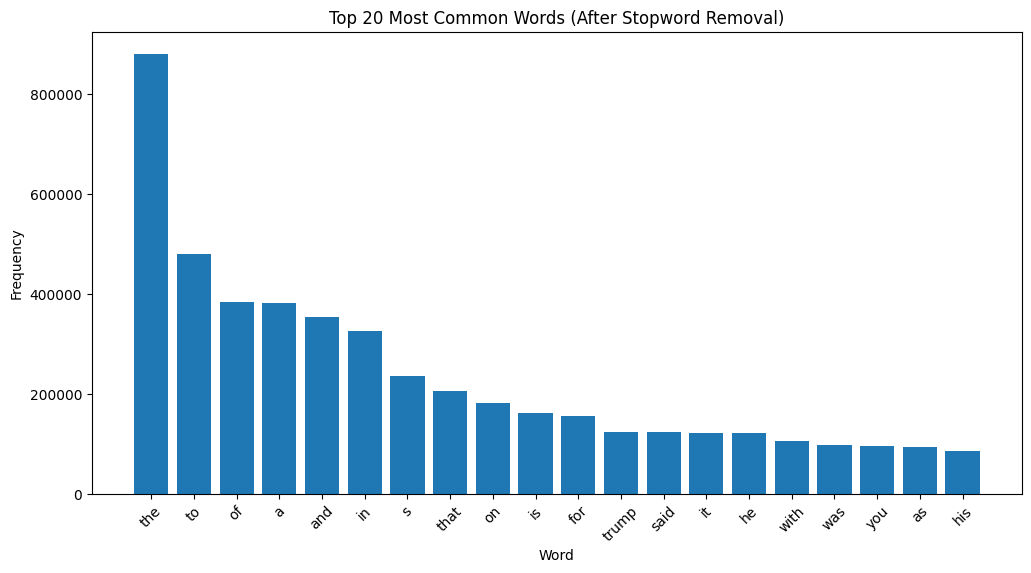

In [233]:
# Flatten the list of tokens from all documents
all_tokens = [token for tokens in df_pre['content'] for token in tokens]

# Count word frequencies
word_freq = Counter(all_tokens)
most_common_words = word_freq.most_common(20)

# Plot
words, counts = zip(*most_common_words)
plt.figure(figsize=(12,6))
plt.bar(words, counts)
plt.title('Top 20 Most Common Words (After Stopword Removal)')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [234]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

df_pre['content'] = df_pre['content'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])
df_pre.head()


,content,label
0,"[donald, trump, sends, embarrassing, new, year...",noncredible
1,"[drunk, bragging, trump, staffer, started, rus...",noncredible
2,"[sheriff, david, clarke, becomes, internet, jo...",noncredible
3,"[trump, obsessed, even, obama, name, coded, we...",noncredible
4,"[pope, francis, called, donald, trump, christm...",noncredible


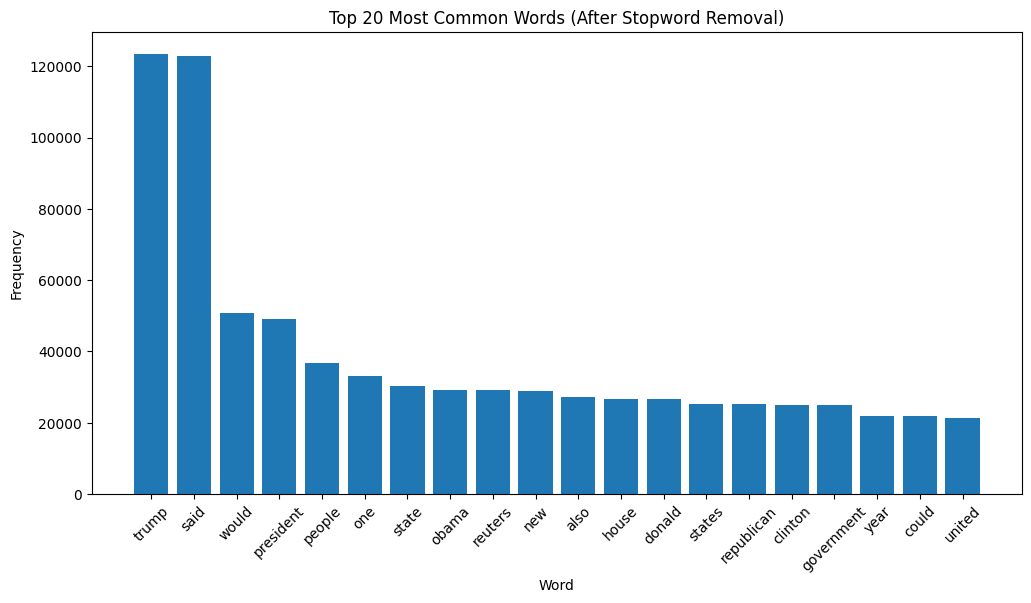

In [235]:
# Flatten the list of tokens from all documents
all_tokens = [token for tokens in df_pre['content'] for token in tokens]

# Count word frequencies
word_freq = Counter(all_tokens)
most_common_words = word_freq.most_common(20)

# Plot
words, counts = zip(*most_common_words)
plt.figure(figsize=(12,6))
plt.bar(words, counts)
plt.title('Top 20 Most Common Words (After Stopword Removal)')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## Lematization

In [236]:
from nltk.stem import WordNetLemmatizer

# make it a lambda function later !!

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

df_pre['content'] = df_pre['content'].apply(lemmatize_tokens)
df_pre.head()

,content,label
0,"[donald, trump, sends, embarrassing, new, year...",noncredible
1,"[drunk, bragging, trump, staffer, started, rus...",noncredible
2,"[sheriff, david, clarke, becomes, internet, jo...",noncredible
3,"[trump, obsessed, even, obama, name, coded, we...",noncredible
4,"[pope, francis, called, donald, trump, christm...",noncredible


## Train Test Split

### Shuffle the data

In [237]:
df_pre = df_pre.sample(frac=1, random_state=42).reset_index(drop=True)
df_pre

,content,label
0,"[many, lost, voter, say, found, candidate, tru...",credible
1,"[iranian, revolutionary, guard, commander, ano...",credible
2,"[cambodian, leader, get, china, backing, west,...",credible
3,"[ex, kkk, grand, wizard, maine, gov, right, ca...",noncredible
4,"[finger, wagging, granny, hillary, clinton, bl...",noncredible
...,...,...
39100,"[hillary, message, former, miss, universe, cal...",noncredible
39101,"[senior, cia, intel, wiretapping, trump, trans...",noncredible
39102,"[ex, georgian, leader, kash, vili, barge, acro...",credible
39103,"[trump, stole, idea, north, korean, propaganda...",noncredible


### Spliting

In [238]:
from sklearn.model_selection import train_test_split

df_pre['content_str'] = df_pre['content'].apply(lambda tokens: ' '.join(tokens))

X = df_pre['content_str'] 
y = df_pre['label']


X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(X_train_text.shape, X_test_text.shape, y_train.shape, y_test.shape)

(27373,) (11732,) (27373,) (11732,)


## Feature Selection and Encoding

### Bag of Words

In [239]:
# --- Bag of Words (BOW) Feature Extraction ---

from sklearn.feature_extraction.text import CountVectorizer

# Create the vectorizer (you can adjust max_features or min_df as needed)
vectorizer = CountVectorizer( min_df = 10, max_df=0.7 , max_features=5000, ngram_range=(1, 2))

# Fit on training data and transform both train and test
X_train_bow = vectorizer.fit_transform(X_train_text)
X_test_bow = vectorizer.transform(X_test_text)

# Convert to DataFrame for better visualization
feature_names = vectorizer.get_feature_names_out()
bow_df = pd.DataFrame(X_train_bow.toarray(), columns=feature_names)
bow_df.head()

,aad,ab,abandon,abandoned,abbas,abc,abc news,abdullah,abed,ability,...,yr,zar,ze,zealand,zero,zi,zi ka,zimbabwe,zone,zuma
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Modeling
This section covers the process of building and evaluating machine learning models for classifying news articles as credible or non-credible

In [240]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train the model
lr_model = LogisticRegression()
lr_model.fit(X_train_bow, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [ ]:
# Predict on test set
y_pred = lr_model.predict(X_test_bow)

# Predict on train set
y_pred_train = lr_model.predict(X_train_bow)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9957381520627344
              precision    recall  f1-score   support

    credible       0.99      1.00      1.00      6359
 noncredible       1.00      0.99      1.00      5373

    accuracy                           1.00     11732
   macro avg       1.00      1.00      1.00     11732
weighted avg       1.00      1.00      1.00     11732



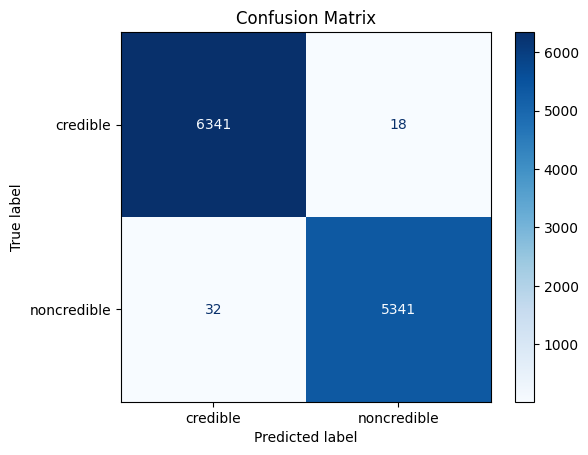

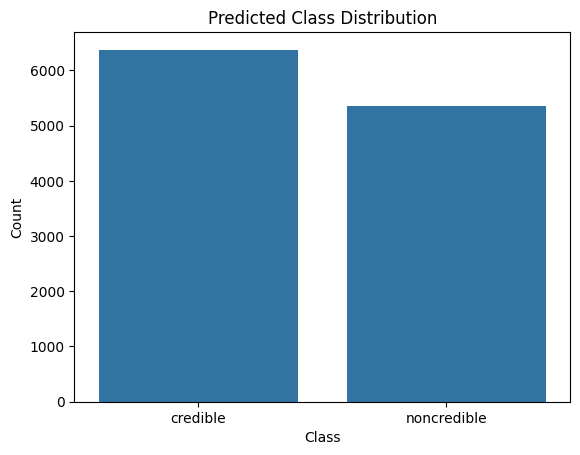

In [242]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=lr_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Bar plot 
sns.countplot(x=y_pred)
plt.title('Predicted Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [243]:
end = time.time()
elapsed_minutes = (end - start) / 60
print(f"Elapsed time: {elapsed_minutes:.2f} minutes")

Elapsed time: 137.70 minutes


### manual testing

In [244]:
def preprocess(text):
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]{1,15}\b', '', text)
    text = re.sub(r'\b\w+\.\w+\.(com|org|net|gov|edu|info|io|co|us|uk|in|au|ca|de|fr|ru|jp|cn|br|za)\b', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [245]:
test_text = ["""U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sundayâ€™s unity march against terrorism.

Kerry said he expects to arrive in Paris Thursday evening, as he heads home after a week abroad. He said he will fly to France at the conclusion of a series of meetings scheduled for Thursday in Sofia, Bulgaria. He plans to meet the next day with Foreign Minister Laurent Fabius and President Francois Hollande, then return to Washington.

The visit by Kerry, who has family and childhood ties to the country and speaks fluent French, could address some of the criticism that the United States snubbed France in its darkest hour in many years.

The French press on Monday was filled with questions about why neither President Obama nor Kerry attended Sundayâ€™s march, as about 40 leaders of other nations did. Obama was said to have stayed away because his own security needs can be taxing on a country, and Kerry had prior commitments.

Among roughly 40 leaders who did attend was Israeli Prime Minister Benjamin Netanyahu, no stranger to intense security, who marched beside Hollande through the city streets. The highest ranking U.S. officials attending the march were Jane Hartley, the ambassador to France, and Victoria Nuland, the assistant secretary of state for European affairs. Attorney General Eric H. Holder Jr. was in Paris for meetings with law enforcement officials but did not participate in the march.

Kerry spent Sunday at a business summit hosted by Indiaâ€™s prime minister, Narendra Modi. The United States is eager for India to relax stringent laws that function as barriers to foreign investment and hopes Modiâ€™s government will act to open the huge Indian market for more American businesses.

In a news conference, Kerry brushed aside criticism that the United States had not sent a more senior official to Paris as â€œquibbling a little bit.â€ He noted that many staffers of the American Embassy in Paris attended the march, including the ambassador. He said he had wanted to be present at the march himself but could not because of his prior commitments in India.

â€œBut that is why I am going there on the way home, to make it crystal clear how passionately we feel about the events that have taken place there,â€ he said.

â€œAnd I donâ€™t think the people of France have any doubts about Americaâ€™s understanding of what happened, of our personal sense of loss and our deep commitment to the people of France in this moment of trauma.â€"""]

# text from a different dataset  didnt have time to encomerate a validationd ata set

test_text_clean = [preprocess(t) for t in test_text]
test_vector = vectorizer.transform(test_text_clean)
y_manual_pred = lr_model.predict(test_vector)
print("Prediction:", y_manual_pred)

Prediction: ['credible']


# VALIDATION

In [246]:
# Import the dataset
news_df = pd.read_csv('news.csv')

# Remove the index column if it exists (commonly named 'Unnamed: 0' or similar)
if 'Unnamed: 0' in news_df.columns:
    news_df = news_df.drop(columns=['Unnamed: 0'])

# Combine 'title' and 'text' into a new 'content' column
news_df['content'] = news_df['title'].astype(str) + ' ' + news_df['text'].astype(str)

# Rename labels
news_df['label'] = news_df['label'].replace({'FAKE': 'noncredible', 'REAL': 'credible'})

# Drop the original 'title' and 'text' columns
news_df = news_df.drop(columns=['title', 'text'])

# Display the first few rows
news_df.head()

,label,content
0,noncredible,You Can Smell Hillary’s Fear Daniel Greenfield...
1,noncredible,Watch The Exact Moment Paul Ryan Committed Pol...
2,credible,Kerry to go to Paris in gesture of sympathy U....
3,noncredible,Bernie supporters on Twitter erupt in anger ag...
4,credible,The Battle of New York: Why This Primary Matte...


In [ ]:

# Convert all text to lowercase
news_df['content_clean'] = news_df['content'].str.lower()

# Expand contractions (e.g., "can't" -> "cannot")
news_df['content_clean'] = news_df['content_clean'].apply(contractions.fix)

# Remove email addresses
news_df['content_clean'] = news_df['content_clean'].apply(
    lambda text: re.sub(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', '', text)
)

# Remove Twitter usernames (e.g., @username)
news_df['content_clean'] = news_df['content_clean'].apply(
    lambda text: re.sub(r'@[A-Za-z0-9_]{1,15}\b', '', text)
)

# Remove domain-like patterns (e.g., abc.xyz.com, abc.xyz.org, etc.)
news_df['content_clean'] = news_df['content_clean'].apply(
    lambda text: re.sub(r'\b\w+\.\w+\.(com|org|net|gov|edu|info|io|co|us|uk|in|au|ca|de|fr|ru|jp|cn|br|za)\b', '', text)
)

# Remove HTML tags
news_df['content_clean'] = news_df['content_clean'].apply(
    lambda text: re.sub(r'<.*?>', '', text)
)

# Remove URLs (http, https, www)
news_df['content_clean'] = news_df['content_clean'].apply(
    lambda text: re.sub(r'http\S+|www\.\S+', '', text)
)

# Remove special characters (anything not a word or whitespace)
news_df['content_clean'] = news_df['content_clean'].apply(
    lambda text: re.sub(r'[^\w\s]', '', text)
)

# Remove digits
news_df['content_clean'] = news_df['content_clean'].apply(
    lambda text: re.sub(r'\d', '', text)
)

# Remove extra (consecutive) whitespaces and strip leading/trailing spaces
news_df['content_clean'] = news_df['content_clean'].apply(
    lambda text: re.sub(r'\s+', ' ', text).strip()
)

# Tokenize the cleaned text
news_df['content_clean'] = news_df['content_clean'].apply(word_tokenize)

# Remove stopwords from the tokenized list
news_df['content_clean'] = news_df['content_clean'].apply(
    lambda tokens: [word for word in tokens if word not in stop_words]
)

# Lemmatize each token
news_df['content_clean'] = news_df['content_clean'].apply(
    lambda tokens: [lemmatizer.lemmatize(token) for token in tokens]
)

# Show the first few rows of the processed DataFrame
news_df['content_clean', 'label'].head()

,label,content,content_clean
0,noncredible,You Can Smell Hillary’s Fear Daniel Greenfield...,"[smell, hillary, fear, daniel, greenfield, shi..."
1,noncredible,Watch The Exact Moment Paul Ryan Committed Pol...,"[watch, exact, moment, paul, ryan, committed, ..."
2,credible,Kerry to go to Paris in gesture of sympathy U....,"[kerry, go, paris, gesture, sympathy, yous, se..."
3,noncredible,Bernie supporters on Twitter erupt in anger ag...,"[bernie, supporter, twitter, erupt, anger, dnc..."
4,credible,The Battle of New York: Why This Primary Matte...,"[battle, new, york, primary, matter, primary, ..."


In [250]:
news_df[['content_clean', 'label']].head()

,content_clean,label
0,"[smell, hillary, fear, daniel, greenfield, shi...",noncredible
1,"[watch, exact, moment, paul, ryan, committed, ...",noncredible
2,"[kerry, go, paris, gesture, sympathy, yous, se...",credible
3,"[bernie, supporter, twitter, erupt, anger, dnc...",noncredible
4,"[battle, new, york, primary, matter, primary, ...",credible


In [248]:
val = news_df['content_clean'].apply(lambda tokens: ' '.join(tokens))
val_bow = vectorizer.transform(val)  # Use transform, not fit_transform, to match training features


# Run predictions on the validation dataset
val_pred = lr_model.predict(val_bow)

# Show prediction counts
print("Validation prediction counts:", Counter(val_pred))


# Evaluate the model on the validation set (news_df['label'])
print("Validation Accuracy:", accuracy_score(news_df['label'], val_pred))
print(classification_report(news_df['label'], val_pred))

Validation prediction counts: Counter({'noncredible': 5615, 'credible': 720})
Validation Accuracy: 0.5581689029202841
              precision    recall  f1-score   support

    credible       0.76      0.17      0.28      3171
 noncredible       0.53      0.95      0.68      3164

    accuracy                           0.56      6335
   macro avg       0.65      0.56      0.48      6335
weighted avg       0.65      0.56      0.48      6335

